<a href="https://colab.research.google.com/github/maytlim/doh_data/blob/main/labresults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import re
import pandas as pd
import datetime
import gdown
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (4.0.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
try:
  import pdfx
except ModuleNotFoundError:
  !pip -q install pdfx
  import pdfx

In [3]:
#Code from https://gist.github.com/korakot/51a917e1f53891d53be223439b0f75c1
from google.colab import auth
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  #gdrive = build('drive', 'v3').files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
  for fid in folder_list(folder_id):
    !gdown -q --id $fid

'''list all ids and filenames of files directly under folder folder_id'''
def folder_list_named(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  return [[f['id'], f['name']] for f in res['files']]

'''download specific file from a gdrive folder to current directory'''
def folder_download_specific(folder_id, search_term):
  for fid, fname in folder_list_named(folder_id):
    found = re.search(search_term, fname)
    if found:
      !gdown -q --id $fid

In [4]:
def folder_list_test(folder_id):
  from googleapiclient.discovery import build
  gdrive = build('drive', 'v3', cache_discovery=False).files()
  res = gdrive.list(q="'%s' in parents" % folder_id).execute()
  for f in res['files']:
    print(f)
  return [f['id'] for f in res['files']]

In [5]:
ddrop_readme = requests.get('http://bit.ly/DataDropPH').url
ddrop_readme = ddrop_readme.split('/')[-1].split('?')[0]
#print(ddrop_readme)
!rm *.pdf #remove existing pdf file before downloading 
folder_download(ddrop_readme)

In [6]:
readme_pdf = !ls *.pdf
readme_pdf = readme_pdf[0][1:-1]
readme_pdf
pdfx_tmp = pdfx.PDFx(readme_pdf)
ddlinks = pdfx_tmp.get_references_as_dict()

In [7]:
month_day = readme_pdf.split('_')
month = int(month_day[0][-2:])
day = int(month_day[1][:2])
month, day
year = 2021
print('DOH DataDrop Release:', year, month, day)

DOH DataDrop Release: 2021 12 30


In [8]:
search_term = 'Testing Aggregates'
downloaded = False
for ddlink in ddlinks['url']:
  if downloaded == False:
    if ddlink[:15] == 'https://bit.ly/' and ddlink[-3:] != 'ive':
      datadrop = requests.get(ddlink).url
      datadrop = datadrop.split('/')[-1].split('?')[0]
      #folder_download(datadrop)
      folder_download_specific(datadrop, search_term)
      print(search_term, '... downloaded')
      downloaded = True
  else:
    continue

Testing Aggregates ... downloaded


In [9]:
data_date = datetime.datetime(year, month, day)
#data_dir ='DOH COVID Data Drop_'  + data_date.strftime('%Y%m%d') + '/'

In [10]:
# testing aggregates - reporting labs
labs_filename = 'DOH COVID Data Drop_ ' + data_date.strftime('%Y%m%d') + ' - 07 Testing Aggregates.csv'
print('testing labs report:', labs_filename)

testing labs report: DOH COVID Data Drop_ 20211230 - 07 Testing Aggregates.csv


In [11]:
df_labs = pd.read_csv(labs_filename)
df_labs.keys()
date_labels = ['report_date']
for label in date_labels:
  df_labs[label] = pd.to_datetime(df_labs[label])

In [12]:
reg_lookup = {'ROF': 'ROF', 'NCR': 'NCR', 'BARMM': 'BARMM', 'CAR': 'CAR', 
              'I': 'Region I: Ilocos Region', 'II': 'Region II: Cagayan Valley', 'III': 'Region III: Central Luzon', 'IV-A': 'Region IV-A: CALABARZON',
              'IV-B': 'Region IV-B: MIMAROPA', 'V': 'Region V: Bicol Region', 'VI': 'Region VI: Western Visayas', 'VII': 'Region VII: Central Visayas',
              'VIII': 'Region VIII: Eastern Visayas', 'IX': 'Region IX: Zamboanga Peninsula', 'X': 'Region X: Northern Mindanao', 
              'XI': 'Region XI: Davao Region', 'XII': 'Region XII: SOCCSKSARGEN', 'XIII': 'CARAGA'}

def filter_condition(df, condition, by='RegionRes'):
  filter = df[by] == condition
  df_filtered = df[filter]
  return df_filtered

In [13]:
!gdown -q 'https://raw.githubusercontent.com/maytlim/doh_data/main/nhfr.json'
nhfr = pd.read_json('nhfr.json')

In [14]:
#grab the region and province of the testing labs from the the NHFR (https://nhfr.doh.gov.ph/)
lab_addy = nhfr[['Health Facility Code', 'Region Name', 'Province Name']]

In [15]:
#Testing Aggregates.csv file does not contain the lab hfhudcodes -- this part is a workaround
#Kludge: when the lab name does not appear in the NHFR, manually find the address and use an hfhudcode of a facility in the same city
#In labslist.xls, these labs appear with an hfhudcode but no nhfr_name
#To do: Encode the listing from the DOH daily report
!curl -O 'https://raw.githubusercontent.com/maytlim/doh_data/main/labslist.xls'
lab_list = pd.read_excel('labslist.xls')
lab_list = lab_list.merge(how='left', right=lab_addy, left_on='hfhudcode', right_on='Health Facility Code')
lab_list.drop(['hfhudcode', 'short_code', 'Health Facility Code', 'nhfr_name'], axis=1, inplace=True)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64512  100 64512    0     0   516k      0 --:--:-- --:--:-- --:--:--  516k


In [16]:
df_labs = df_labs.merge(how='left', right=lab_list, left_on='facility_name', right_on='lab_name')

In [17]:
reg_lookup = {'NCR': 'NATIONAL CAPITAL REGION (NCR)',  
              'CAR': 'CORDILLERA ADMINISTRA TIVE REGION (CAR)', 'I': 'REGION I (ILOCOS REGION)', 
              'II': 'REGION II (CAGAYAN VALLEY)', 'III': 'REGION III (CENTRAL LUZON)', 
              'IV-A': 'REGION IV-A (CALABAR ZON)', 'IV-B': 'REGION IV-B (MIMAROPA)', 
              'V': 'REGION V (BICOL REGION)', 'VI': 'REGION VI (WESTERN VISAYAS)', 
              'VII': 'REGION VII (CENTRAL VISAYAS)', 'VIII': 'REGION VIII (EASTERN VISAYAS)', 
              'IX': 'REGION IX (ZAMBOANGA PENINSULA)', 'X': 'REGION X (NORTHERN MINDANAO)', 
              'XI': 'REGION XI (DAVAO REGION)', 'XII': 'REGION XII (SOCCSKSA RGEN)', 
              'XIII': 'REGION XIII (CARAGA)', 'BARMM': 'AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM)'}

In [18]:
dma = 7
df_results = df_labs.groupby(['Region Name', 'report_date']).sum()[['daily_output_unique_individuals', 'daily_output_positive_individuals', 'daily_output_samples_tested']]
df_results['daily_positivity'] = df_results['daily_output_positive_individuals'] / df_results['daily_output_unique_individuals']
df_plot = df_results['daily_positivity'].unstack(level=0)

In [19]:
start_date = datetime.datetime(2021, 1, 1)
#end_date = datetime.datetime.today()
filter = (df_plot.index >= start_date)
df_plot = df_plot[filter]
df_plot = df_plot.rolling(window=dma).mean()

In [20]:
df_tests = df_results['daily_output_unique_individuals'].unstack(level=0)
df_positives = df_results['daily_output_positive_individuals'].unstack(level=0)
start_date = datetime.datetime(2021, 1, 1)
#end_date = datetime.datetime.today()
filter = (df_tests.index >= start_date)
df_tests = df_tests[filter].astype(int)
df_tests['TOTAL'] = df_tests.sum(axis=1)
df_tests.tail(7)

Region Name,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),CORDILLERA ADMINISTRA TIVE REGION (CAR),NATIONAL CAPITAL REGION (NCR),REGION I (ILOCOS REGION),REGION II (CAGAYAN VALLEY),REGION III (CENTRAL LUZON),REGION IV-A (CALABAR ZON),REGION IV-B (MIMAROPA),REGION IX (ZAMBOANGA PENINSULA),REGION V (BICOL REGION),REGION VI (WESTERN VISAYAS),REGION VII (CENTRAL VISAYAS),REGION VIII (EASTERN VISAYAS),REGION X (NORTHERN MINDANAO),REGION XI (DAVAO REGION),REGION XII (SOCCSKSA RGEN),REGION XIII (CARAGA),TOTAL
report_date,,,,,,,,,,,,,,,,,,
2021-12-23,70,523,14100,448,309,1438,3037,45,301,40,1525,788,64,218,651,270,194,24021
2021-12-24,69,326,10997,368,392,1637,2140,41,300,15,1332,532,182,198,466,226,169,19390
2021-12-25,77,170,6383,315,211,1573,1479,22,243,96,584,803,276,92,392,96,116,12928
2021-12-26,53,294,8583,398,233,1466,1697,37,139,9,673,1530,137,168,506,195,205,16323
2021-12-27,105,426,13786,661,307,1771,2534,21,239,52,1397,1269,192,343,914,254,184,24455
2021-12-28,0,511,16925,641,361,1723,2228,38,298,40,1352,1095,384,310,627,303,262,27098
2021-12-29,0,208,16747,340,363,1956,2784,38,204,37,1367,838,299,282,688,275,186,26612


In [21]:
df_positives = df_positives[filter].astype(int)
df_positives['TOTAL'] = df_positives.sum(axis=1)
df_positives.tail(7)

Region Name,AUTONOMOUS REGION IN MUSLIM MINDANAO (ARMM),CORDILLERA ADMINISTRA TIVE REGION (CAR),NATIONAL CAPITAL REGION (NCR),REGION I (ILOCOS REGION),REGION II (CAGAYAN VALLEY),REGION III (CENTRAL LUZON),REGION IV-A (CALABAR ZON),REGION IV-B (MIMAROPA),REGION IX (ZAMBOANGA PENINSULA),REGION V (BICOL REGION),REGION VI (WESTERN VISAYAS),REGION VII (CENTRAL VISAYAS),REGION VIII (EASTERN VISAYAS),REGION X (NORTHERN MINDANAO),REGION XI (DAVAO REGION),REGION XII (SOCCSKSA RGEN),REGION XIII (CARAGA),TOTAL
report_date,,,,,,,,,,,,,,,,,,
2021-12-23,0,4,224,9,15,22,28,4,20,3,28,8,1,2,8,5,1,382
2021-12-24,0,1,269,4,6,19,49,2,14,1,15,2,2,5,8,12,2,411
2021-12-25,0,1,206,4,4,27,10,1,8,0,8,3,5,1,9,0,4,291
2021-12-26,0,9,283,11,4,25,23,1,12,0,11,22,2,3,3,9,9,427
2021-12-27,4,21,739,15,6,64,177,3,22,0,25,13,1,10,8,9,4,1121
2021-12-28,0,12,1364,7,13,81,193,3,12,0,32,14,3,6,12,7,8,1767
2021-12-29,0,9,2344,11,12,92,191,1,8,2,25,8,5,9,7,10,8,2742


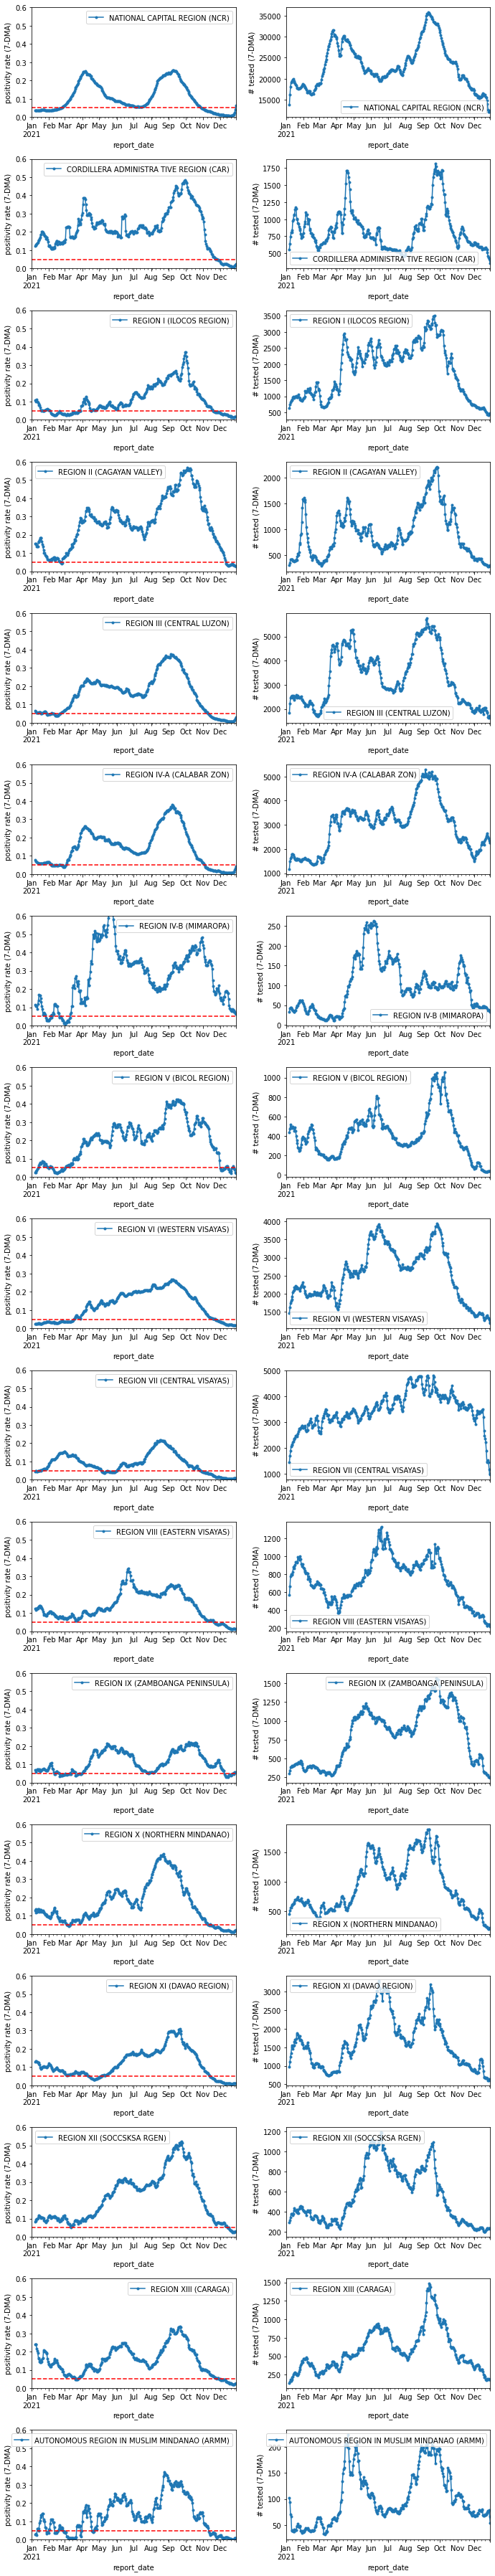

In [22]:
fig, axes = plt.subplots(nrows=len(reg_lookup), ncols=2, sharex=False, figsize=(10, 50))
for i, reg in enumerate(reg_lookup):
  df_positives[reg_lookup[reg]] = df_positives[reg_lookup[reg]].rolling(window=dma).mean()
  df_tests[reg_lookup[reg]] = df_tests[reg_lookup[reg]].rolling(window=dma).mean()
  df_positivity = df_positives[reg_lookup[reg]]/df_tests[reg_lookup[reg]]
  df_positivity.plot(ax=axes[i][0], ylim=[0,0.6], legend=True, ylabel='positivity rate (7-DMA)', marker='.')
  l2=axes[i][0].axhline(0.05,color='red',ls='--')
  df_tests[reg_lookup[reg]].plot(ax=axes[i][1], legend=True, ylabel='# tested (7-DMA)', marker='.')
fig.tight_layout()

In [23]:
df_labs['daily_positivity'] = df_labs['daily_output_positive_individuals']/df_labs['daily_output_unique_individuals']


In [24]:
#df_labs.keys()

In [25]:
def show_hospital_details(df, hosp_name, by='daily_output_positive_individuals', min_threshold=15, show_num=5):
  filter = (df[by] > min_threshold) & (df_labs['facility_name'] == hosp_name)
  show_columns = ['report_date','daily_output_unique_individuals',
                  'daily_output_positive_individuals', 'facility_name']
  return df[filter][show_columns].tail(show_num) 

In [26]:
def show_labs_list(df, by='daily_positivity', report_date='2021-12-27', cutoff_positivity=0.08, cutoff_count=100):
  filter = (df[by] > cutoff_positivity) & \
    (df['report_date'] == report_date) & \
    (df['daily_output_unique_individuals'] > cutoff_count)
  show_columns = ['report_date', 'daily_output_unique_individuals', 
                  'daily_output_positive_individuals', 'facility_name']
  return df[filter][show_columns]

In [27]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-29', 
               cutoff_positivity=0.08, cutoff_count=100) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
386,2021-12-29,150.0,49.0,A Star Laboratories
873,2021-12-29,298.0,78.0,AL Molecular Diagnostic Laboratory
6155,2021-12-29,103.0,22.0,Asian Hospital and Medical Center
9719,2021-12-29,198.0,41.0,"Be Safe MD, Inc."
10067,2021-12-29,212.0,93.0,Best Diagnostic Corporation
23486,2021-12-29,308.0,79.0,Chinese General Hospital
31016,2021-12-29,153.0,98.0,De La Salle Medical and Health Sciences Institute
32525,2021-12-29,2162.0,177.0,Detoxicare Molecular Diagnostics Laboratory
37659,2021-12-29,554.0,57.0,El Roi Molecular Diagnostic Laboratory
38082,2021-12-29,375.0,57.0,"Ermita Molecular Diagnostic Laboratory, Inc."


In [28]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-28', 
               cutoff_positivity=0.08, cutoff_count=100) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
385,2021-12-28,152.0,39.0,A Star Laboratories
872,2021-12-28,333.0,48.0,AL Molecular Diagnostic Laboratory
9718,2021-12-28,185.0,31.0,"Be Safe MD, Inc."
10066,2021-12-28,180.0,38.0,Best Diagnostic Corporation
23485,2021-12-28,322.0,47.0,Chinese General Hospital
23774,2021-12-28,105.0,18.0,Chinese General Hospital - GeneXpert Laboratory
31015,2021-12-28,133.0,58.0,De La Salle Medical and Health Sciences Institute
37658,2021-12-28,502.0,50.0,El Roi Molecular Diagnostic Laboratory
38081,2021-12-28,411.0,37.0,"Ermita Molecular Diagnostic Laboratory, Inc."
42981,2021-12-28,144.0,15.0,Healthway Medical


In [29]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-27', 
               cutoff_positivity=0.08, cutoff_count=100) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
871,2021-12-27,230.0,23.0,AL Molecular Diagnostic Laboratory
9717,2021-12-27,240.0,25.0,"Be Safe MD, Inc."
10065,2021-12-27,225.0,24.0,Best Diagnostic Corporation
23773,2021-12-27,104.0,12.0,Chinese General Hospital - GeneXpert Laboratory
47022,2021-12-27,121.0,16.0,JT Cenica Medical Health System
69557,2021-12-27,1431.0,153.0,Ospital ng Imus
77029,2021-12-27,125.0,15.0,Philippine General Hospital GeneXpert Laboratory
98986,2021-12-27,170.0,17.0,Singapore Diagnostics
105319,2021-12-27,183.0,46.0,Sta. Ana Hospital - Closed System Molecular La...
111186,2021-12-27,163.0,26.0,The Premier Molecular Diagnostics


In [30]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-28', 
               cutoff_positivity=0.3, cutoff_count=50) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
31015,2021-12-28,133.0,58.0,De La Salle Medical and Health Sciences Institute
103858,2021-12-28,69.0,25.0,St. Luke's Medical Center - Quezon City (SLMC-QC)
105320,2021-12-28,163.0,82.0,Sta. Ana Hospital - Closed System Molecular La...


In [31]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-27', 
               cutoff_positivity=0.3, cutoff_count=50) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
96681,2021-12-27,68.0,30.0,San Lazaro Hospital (SLH)


In [32]:
show_labs_list(df_labs, by='daily_positivity', report_date='2021-12-26', 
               cutoff_positivity=0.08, cutoff_count=100) 

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
23483,2021-12-26,270.0,28.0,Chinese General Hospital
55683,2021-12-26,280.0,24.0,Manila Doctors Hospital


In [33]:
show_hospital_details(df_labs, "Ospital ng Imus", 
                      by='daily_output_positive_individuals', min_threshold=50, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
69464,2021-09-25,451.0,137.0,Ospital ng Imus
69465,2021-09-26,437.0,52.0,Ospital ng Imus
69467,2021-09-28,1363.0,124.0,Ospital ng Imus
69469,2021-09-30,697.0,85.0,Ospital ng Imus
69470,2021-10-01,1314.0,72.0,Ospital ng Imus
69474,2021-10-05,1574.0,70.0,Ospital ng Imus
69477,2021-10-08,1321.0,55.0,Ospital ng Imus
69485,2021-10-16,833.0,56.0,Ospital ng Imus
69557,2021-12-27,1431.0,153.0,Ospital ng Imus
69558,2021-12-28,1106.0,107.0,Ospital ng Imus


In [34]:
show_hospital_details(df_labs, "Manila Doctors Hospital", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=5)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
55619,2021-10-23,405.0,23.0,Manila Doctors Hospital
55637,2021-11-10,429.0,25.0,Manila Doctors Hospital
55683,2021-12-26,280.0,24.0,Manila Doctors Hospital
55685,2021-12-28,227.0,27.0,Manila Doctors Hospital
55686,2021-12-29,295.0,33.0,Manila Doctors Hospital


In [35]:
show_hospital_details(df_labs, "Chinese General Hospital", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
23436,2021-11-09,517.0,20.0,Chinese General Hospital
23437,2021-11-10,324.0,16.0,Chinese General Hospital
23439,2021-11-12,603.0,24.0,Chinese General Hospital
23447,2021-11-20,518.0,20.0,Chinese General Hospital
23479,2021-12-22,348.0,16.0,Chinese General Hospital
23482,2021-12-25,261.0,17.0,Chinese General Hospital
23483,2021-12-26,270.0,28.0,Chinese General Hospital
23484,2021-12-27,285.0,20.0,Chinese General Hospital
23485,2021-12-28,322.0,47.0,Chinese General Hospital
23486,2021-12-29,308.0,79.0,Chinese General Hospital


In [36]:
show_hospital_details(df_labs, "UP-PGH Molecular Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=5)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
114549,2021-10-30,380.0,21.0,UP-PGH Molecular Laboratory
114553,2021-11-03,563.0,22.0,UP-PGH Molecular Laboratory
114607,2021-12-27,234.0,36.0,UP-PGH Molecular Laboratory
114608,2021-12-28,483.0,47.0,UP-PGH Molecular Laboratory
114609,2021-12-29,184.0,27.0,UP-PGH Molecular Laboratory


In [37]:
show_hospital_details(df_labs, "Philippine General Hospital GeneXpert Laboratory", 
                      by='daily_output_positive_individuals', min_threshold=13, show_num=5)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
76981,2021-11-09,103.0,19.0,Philippine General Hospital GeneXpert Laboratory
76985,2021-11-13,72.0,14.0,Philippine General Hospital GeneXpert Laboratory
77029,2021-12-27,125.0,15.0,Philippine General Hospital GeneXpert Laboratory
77030,2021-12-28,123.0,22.0,Philippine General Hospital GeneXpert Laboratory
77031,2021-12-29,102.0,20.0,Philippine General Hospital GeneXpert Laboratory


In [38]:
show_hospital_details(df_labs, "Philippine Children's Medical Center", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=5)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
76674,2021-12-24,854.0,22.0,Philippine Children's Medical Center
76675,2021-12-25,616.0,23.0,Philippine Children's Medical Center
76677,2021-12-27,965.0,37.0,Philippine Children's Medical Center
76678,2021-12-28,963.0,16.0,Philippine Children's Medical Center
76679,2021-12-29,1061.0,65.0,Philippine Children's Medical Center


In [39]:
show_hospital_details(df_labs, "Best Diagnostic Corporation", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
9996,2021-10-19,171.0,35.0,Best Diagnostic Corporation
9997,2021-10-20,174.0,23.0,Best Diagnostic Corporation
9998,2021-10-21,262.0,17.0,Best Diagnostic Corporation
10000,2021-10-23,308.0,19.0,Best Diagnostic Corporation
10003,2021-10-26,172.0,17.0,Best Diagnostic Corporation
10004,2021-10-27,179.0,17.0,Best Diagnostic Corporation
10005,2021-10-28,200.0,22.0,Best Diagnostic Corporation
10065,2021-12-27,225.0,24.0,Best Diagnostic Corporation
10066,2021-12-28,180.0,38.0,Best Diagnostic Corporation
10067,2021-12-29,212.0,93.0,Best Diagnostic Corporation


In [40]:
show_hospital_details(df_labs, "San Lazaro Hospital (SLH)", by='daily_output_positive_individuals', min_threshold=15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
96610,2021-10-17,297.0,42.0,San Lazaro Hospital (SLH)
96612,2021-10-19,87.0,24.0,San Lazaro Hospital (SLH)
96613,2021-10-20,235.0,39.0,San Lazaro Hospital (SLH)
96615,2021-10-22,166.0,16.0,San Lazaro Hospital (SLH)
96616,2021-10-23,159.0,19.0,San Lazaro Hospital (SLH)
96621,2021-10-28,182.0,21.0,San Lazaro Hospital (SLH)
96622,2021-10-29,138.0,16.0,San Lazaro Hospital (SLH)
96636,2021-11-12,132.0,17.0,San Lazaro Hospital (SLH)
96681,2021-12-27,68.0,30.0,San Lazaro Hospital (SLH)
96683,2021-12-29,104.0,39.0,San Lazaro Hospital (SLH)


In [41]:
show_hospital_details(df_labs, "Sta. Ana Hospital - Closed System Molecular Laboratory (RT PCR)", 
                      by='daily_output_positive_individuals', min_threshold=15, show_num=10)

,report_date,daily_output_unique_individuals,daily_output_positive_individuals,facility_name
105250,2021-10-19,356.0,28.0,Sta. Ana Hospital - Closed System Molecular La...
105251,2021-10-20,353.0,33.0,Sta. Ana Hospital - Closed System Molecular La...
105253,2021-10-22,271.0,22.0,Sta. Ana Hospital - Closed System Molecular La...
105254,2021-10-23,350.0,24.0,Sta. Ana Hospital - Closed System Molecular La...
105257,2021-10-26,367.0,24.0,Sta. Ana Hospital - Closed System Molecular La...
105259,2021-10-28,363.0,16.0,Sta. Ana Hospital - Closed System Molecular La...
105266,2021-11-04,277.0,17.0,Sta. Ana Hospital - Closed System Molecular La...
105319,2021-12-27,183.0,46.0,Sta. Ana Hospital - Closed System Molecular La...
105320,2021-12-28,163.0,82.0,Sta. Ana Hospital - Closed System Molecular La...
105321,2021-12-29,183.0,87.0,Sta. Ana Hospital - Closed System Molecular La...


In [42]:
def juxtapose_spread(df, show_date1, show_date2):
  show_date = '2021-12-29'
  filter1 = (df_labs['report_date'] == show_date1)
  filter2 = (df_labs['report_date'] == show_date2)
  xhigh = max(df_labs[filter1]['daily_output_positive_individuals'].max(), 
    df_labs[filter2]['daily_output_positive_individuals'].max())
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  ax1.plot(df_labs[filter1]['daily_output_positive_individuals'], 
         df_labs[filter1]['daily_positivity']*100, 'k.', alpha=0.3)
  ax1.set_ylabel('positivity (%)')
  ax1.set_xlabel('positive cases')
  ax1.set_xlim(right=xhigh+5)
  ax1.set_ylim(top=100) 
  ax1.set_title(show_date1)

  ax2.plot(df_labs[filter2]['daily_output_positive_individuals'], 
         df_labs[filter2]['daily_positivity']*100, 'k.', alpha=0.3)
  ax2.set_ylabel('positivity (%)')
  ax2.set_xlabel('positive cases') 
  ax2.set_xlim(right=xhigh+5)
  ax2.set_ylim(top=100) 
  ax2.set_title(show_date2)

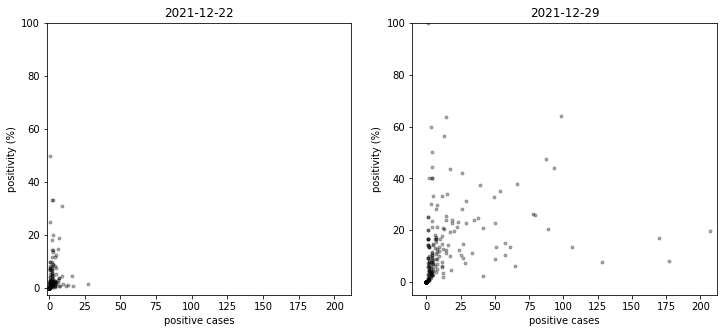

In [43]:
juxtapose_spread(df_labs, '2021-12-22', '2021-12-29')

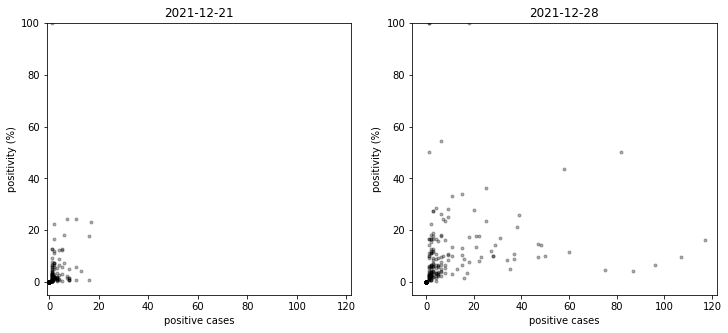

In [44]:
juxtapose_spread(df_labs, '2021-12-21', '2021-12-28')

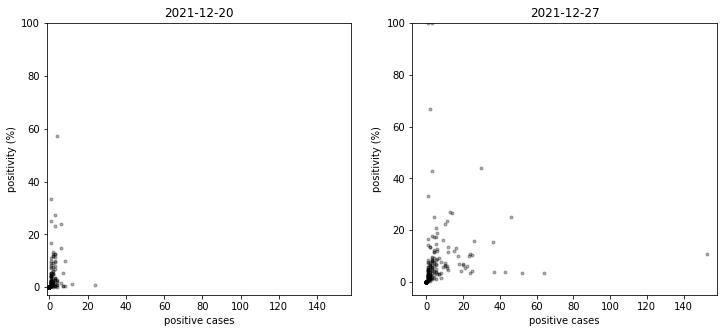

In [45]:
juxtapose_spread(df_labs, '2021-12-20', '2021-12-27')

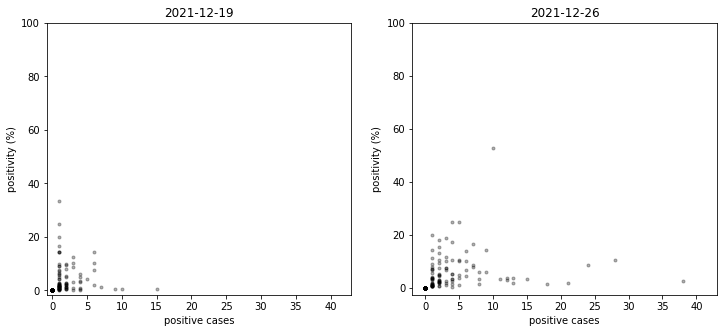

In [46]:
juxtapose_spread(df_labs, '2021-12-19', '2021-12-26')

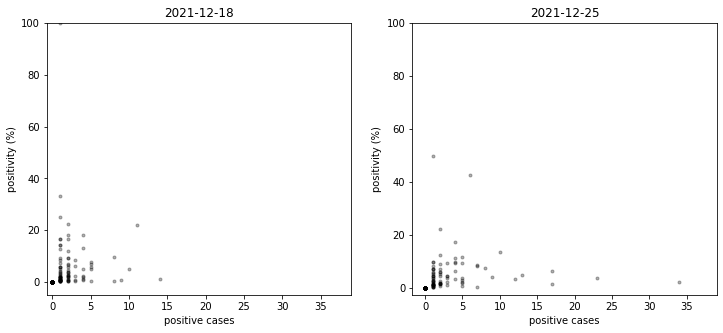

In [47]:
juxtapose_spread(df_labs, '2021-12-18', '2021-12-25')

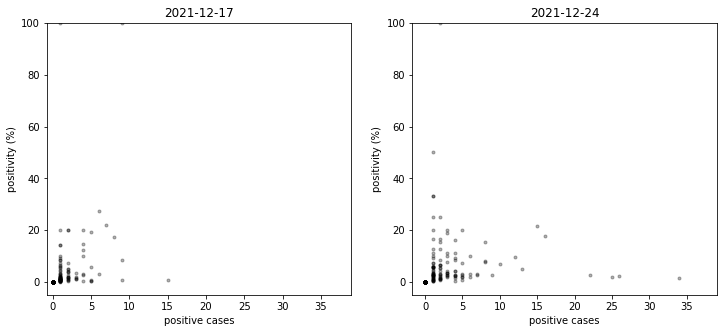

In [48]:
juxtapose_spread(df_labs, '2021-12-17', '2021-12-24')

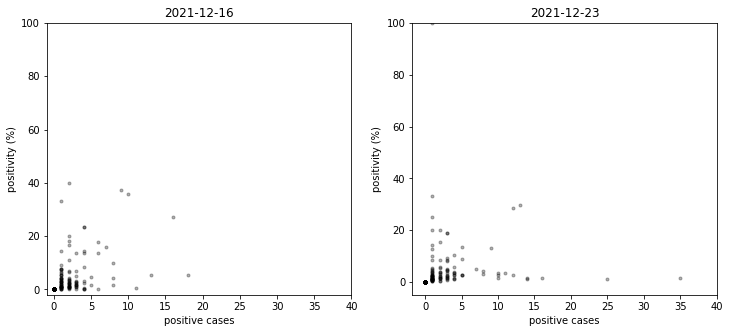

In [49]:
juxtapose_spread(df_labs, '2021-12-16', '2021-12-23')

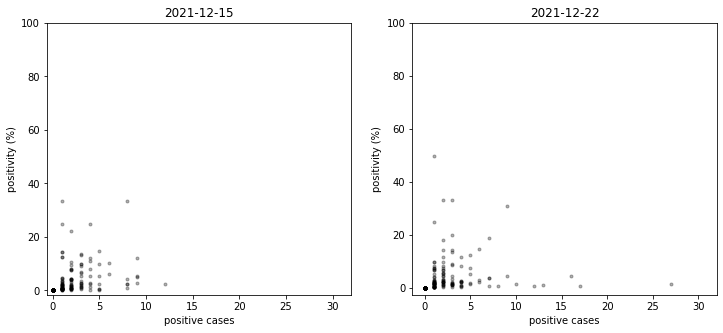

In [50]:
juxtapose_spread(df_labs, '2021-12-15', '2021-12-22')

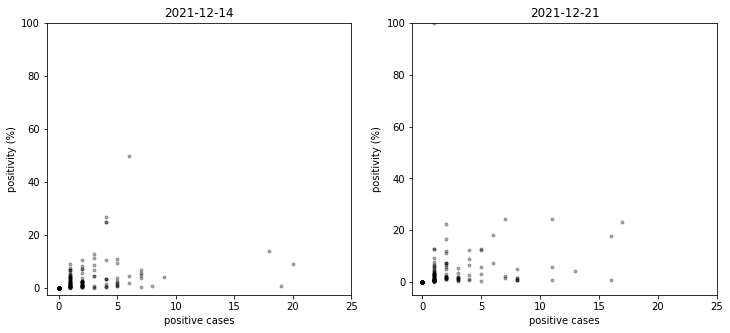

In [51]:
juxtapose_spread(df_labs, '2021-12-14', '2021-12-21')